# **Impainting di immagini satellitari**

Il progetto riguarda il inpainting (ritocco) di immagini, che consiste nel riempire parti deteriorate o mancanti di un'immagine per ricostruire un'immagine completa. Il dataset preso in considerazione è il dataset EuroSAT di tensorflow basato su immagini satellitari Sentinel-2, nella versione rgb. Questo comprende 27000 immagini, a risoluzione 64x64.

# Installazioni e imports

In [ ]:
import tensorflow as tf
import keras
from keras.losses import mean_squared_error as keras_mse
from tensorflow.python.keras.utils import conv_utils
from sklearn.metrics import mean_squared_error as sklearn_mse
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Concatenate, concatenate, BatchNormalization, LeakyReLU
from keras.losses import mean_squared_error
from keras.models import Model
from keras.metrics import MeanIoU
from keras.optimizers import Adam, SGD
from keras.utils import plot_model
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import cv2
from tqdm import tqdm
from keras import backend as K

# Funzioni utilizzate

In [ ]:
def generator(dataset,nolines=9):
    '''
    Generatore fornito assieme al notebook di partenza.
    Modifica le immagini effettuando il painting attraverso linee nere sulle immagini originali nei batch.

    Args:
      dataset: dataset contentente i batch con le immagini originali.
      nolines: numero di linee con cui comporre la maschera.

    Yields:
      tuple: tupla contenente due array numPy, della forma (immagine mascherata, immagine originale)

    Notes:
      - La maschera viene creata aggiungendo linee con orientamento casuale all'immagine.
      - Le immagini vengono normalizzate.
    '''
    while True:  # Start an infinite loop
        for batch in dataset:
            images = batch["image"]
            images_np = images.numpy()

            masks = np.zeros((batch_size, 64, 64))
            for i in range(batch_size):
                for j in range(nolines):
                    start_point = (np.random.randint(0, 64 - 1), 0)
                    end_point = (np.random.randint(0, 64 - 1), 63)
                    thickness = np.random.randint(2, 3)
                    masks[i] = cv2.line(masks[i], start_point, end_point, (1), thickness)

            images_np = images_np / 255.0
            masks = np.stack(((masks),) * 3, axis=-1)

            yield (images_np * masks, images_np)

def dice_coef(y_true, y_pred, const=K.epsilon()):
    '''
    Calcola il coefficiente di Sørensen–Dice tra due tensori 2D.
    È calcolato come (2 * TP) / (2 * TP + FP + FN), dove TP sono i veri positivi, FP sono i falsi positivi e FN sono i falsi negativi.
    Alternativa di metrica rispetto alla Intersection Over Union.

    Args:
        y_true: tensore contenente la ground truth
        y_pred: tensore contenente la prediction
        const (float): costante > 0 per evitare divisioni per zero. Predefinita è K.epsilon().

    Returns:
        float: coefficente calcolato
    '''
    y_true_pos = tf.reshape(y_true, [-1])
    y_pred_pos = tf.reshape(y_pred, [-1])

    # true pos (TP), false neg (FN), false pos (FP).
    true_pos  = tf.reduce_sum(y_true_pos * y_pred_pos)
    false_neg = tf.reduce_sum(y_true_pos * (1-y_pred_pos))
    false_pos = tf.reduce_sum((1-y_true_pos) * y_pred_pos)
    coef_val = (2.0 * true_pos + const)/(2.0 * true_pos + false_pos + false_neg)
    return coef_val

# Preparazione del dataset

In [ ]:
ds_train, ds_info = tfds.load(
    'eurosat/rgb',
    shuffle_files=False,
    #as_supervised=True,  # Returns a tuple (img, label) instead of a dictionary {'image': img, 'label': label}
    with_info=True
)
ds_train = ds_train['train']
ds_train = ds_train.shuffle(1000, seed = 42)

train_dataset = ds_train.take(20000)
test_dataset = ds_train.skip(20000)
# viene creato un set aggiuntivo per la validazione durante il training, per monitorare overfitting
validation_dataset = ds_train.shuffle(1000, seed=123).take(600)

batch_size = 8
train_dataset_batched = train_dataset.batch(batch_size)
test_dataset_batched = test_dataset.batch(batch_size)
validation_dataset_batched = test_dataset.batch(batch_size)

# Create generators for the batched datasets
train_generator = generator(train_dataset_batched)
test_generator = generator(test_dataset_batched)
validation_generator = generator(validation_dataset_batched)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/eurosat/rgb/2.0.0.incompleteJ9IWG0/eurosat-train.tfrecord*...:   0%|      …

Dataset eurosat downloaded and prepared to /root/tensorflow_datasets/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.


## Visualizzazione del dataset eurosat/rgb

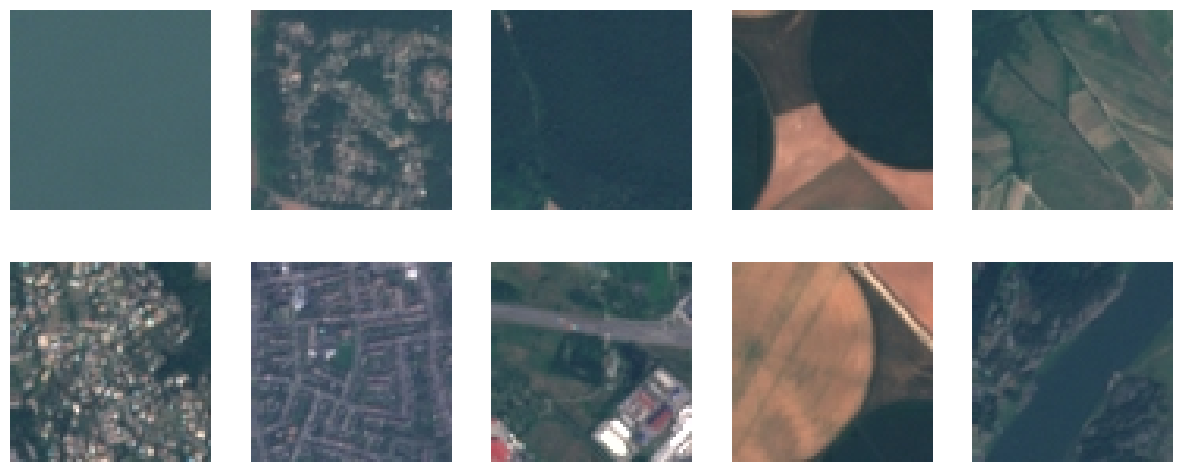

In [ ]:
## Get first 10 images as samples
sample_images = ds_train.take(10);
# grid 2x5 for 10 samples
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

# plot
for i, sample in enumerate(sample_images):
    image = sample['image']
    image_array = image.numpy()
    axes[i // 5, i % 5].imshow(image_array)
    axes[i // 5, i % 5].axis('off')
plt.show()

## Visualizzazione delle immagini mascherate

Nella prima riga é possibile visualizzare le immagini deteriorate (+maschera), nella seconda le immagini originali che il modello mira a ricostruire.

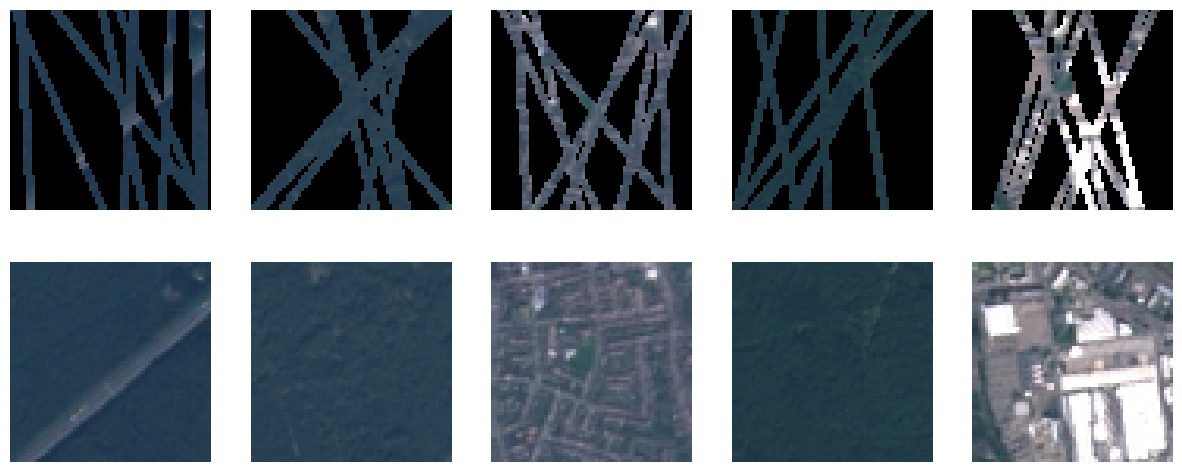

In [ ]:
## Get first 10 images as samples
a,b = next(train_generator)
# grid 2x5 for 10 samples
fig, axes = plt.subplots(nrows = 2, ncols = 5, figsize=(15, 6))

# in alternativa é anche possibile vedere solo le maschere con a[i]/b[i]

# Plot the first 5 images
for i in range(5):
    axes[0, i].imshow(a[i])  # Use cmap='gray' if your images are grayscale
    axes[0, i].axis('off')  # Turn off axis

# Plot the next 5 images
for i in range(5):
    axes[1, i].imshow(b[i])  # Use cmap='gray' if your images are grayscale
    axes[1, i].axis('off')  # Turn off axis

plt.show()

# Definizione del modello

La scelta del modello riguardo al problema di impainting é stata dettata da vari step e architetture che andiamo a descrivere di seguito:
1.   Vista la natura del problema, si é cominciato a pensare a una rete di tipo convoluzionale, in particolare seguendo la classe degli autoencoders, il cui apprendimento é basato su compressione (encoder) e ricostruzione (decoder). Un'architettura efficace di questo tipo é U-net.

2.   I primi test su U-net sono partiti da una struttura standard e abbassando via sperimentazione i filtri e quindi i parametri dei vari layer convoluzionali. Si é anche optato per i layer di Conv2DTranspose al posto di quelli di UpSampling in quanto questi ultimi non completamente deconvolutivi. La valutazione tramite mse e loss risultava bassa ma poco stabile: pesanti variazioni ai filtri peggioravano la metrica.

3. Si é iniziato a valutare di cambiare gli iperparametri, come batch_size e learning_rate. Sebbene inizialmente ció non ha portato ha molto, si é iniziata a sviluppare l'idea di utilizzare diverse fasi di training e batch_size diverse sfruttando la possibilitá data del generatore, in modo da calmierare l'overfitting. Il learning rate dell'optimizer (in questo caso Adam), é stato lasciato invariato in quanto non aumentava/peggiorava in paricolar modo la velocitá di convergenza del training.

4. I risultati miglioravano (nell'ordine del mse = 0.004-0.003), ma erano stagnanti a prescindere dalla complessitá del modello. Sono state diverse funzioni di attivazione (elu, gelu, LeakyReLU), che non hanno comunque portato svolte. Oltre a questo, nella seconda fase di training é stato adibito un validation set in modo da tenere controllata la loss, le metriche e quindi overfitting.

5. Valutando la pesantezza della maschera sul rapporto immagine mascherata / originale, l'archittettura é quindi cambiata in una U-net che fa uso di inception layers, complicando il modello ma facendo sí che potesse catturare le feature a diverse scale spaziali. Il modello dopo un po' di sperimentazione con i filtri é risultato piuttosto vincente rispetto alla controparte standard.
La scelta delle dimensioni di kernel, stride e padding sono state decretate a seguito di diversi tentativi.

6. Infine, il modello finale é presentato di seguito.





Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d_8 (Conv2D)           (None, 64, 64, 8)            224       ['input_1[0][0]']             
                                                                                                  
 conv2d_10 (Conv2D)          (None, 64, 64, 8)            608       ['input_1[0][0]']             
                                                                                                  
 conv2d_13 (Conv2D)          (None, 64, 64, 8)            224       ['input_1[0][0]']             
                                                                                              

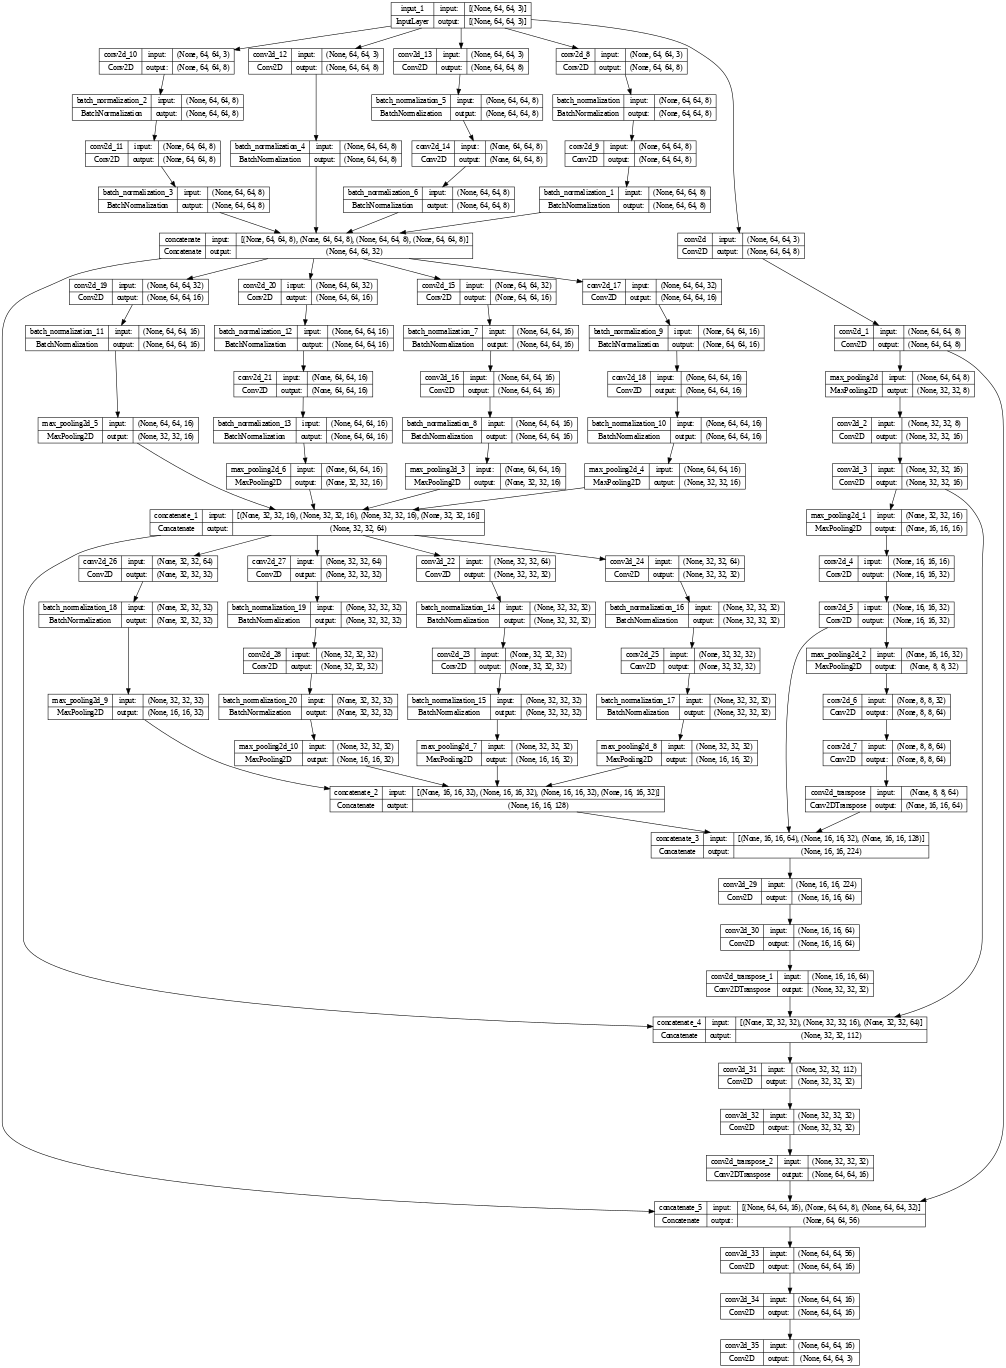

In [ ]:
def normalized_bottleneck_block(inputs, filters1, filters2, kernel_size1, kernel_size2, activation, padding, pooling_layer = True, single_conv = False):
    convx = Conv2D(filters = filters1, kernel_size = kernel_size1, activation = activation, padding = padding)(inputs)
    convx = BatchNormalization()(convx)
    if not single_conv:
      convx = Conv2D(filters = filters2, kernel_size = kernel_size2, activation = activation, padding = padding)(convx)
      convx = BatchNormalization()(convx)
    if pooling_layer:
      convx = MaxPooling2D(pool_size = (2, 2))(convx)
    return convx

def bottleneck_block(inputs, filters1, filters2, pooling_layer = True):
    conv1 = normalized_bottleneck_block(inputs, filters1, filters2, (3, 3), (3, 3), 'relu', 'same', pooling_layer)
    conv2 = normalized_bottleneck_block(inputs, filters1, filters2, (5, 5), (3, 3), 'relu', 'same', pooling_layer)
    conv3 = normalized_bottleneck_block(inputs, filters1, filters2, (1, 1), (1, 1), 'relu', 'same', pooling_layer, True)
    conv4 = normalized_bottleneck_block(inputs, filters1, filters2, (3, 3), (1, 1), 'relu', 'same', pooling_layer)
    up = concatenate([conv1, conv2, conv3, conv4])
    return up

def encoder_block(inputs, filters, kernel_size, pooling_layer = True):
    # togliere il pooling layer dall'ultimo blocco dell'encoder si é dimostrato vincente
    conve = Conv2D(filters = filters, kernel_size = kernel_size, activation='relu', padding='same')(inputs)
    conve = Conv2D(filters = filters, kernel_size = kernel_size, activation='relu', padding='same')(conve)
    if pooling_layer:
      poole = MaxPooling2D(pool_size=(2, 2))(conve)
      return conve, poole
    return conve

def decoder_block(inputs, filters, kernel_size, skip_to_conv, skip_to_bottleneck):
    upd = concatenate([Conv2DTranspose(filters = filters, kernel_size=(2, 2), strides=(2, 2), padding='same')(inputs), skip_to_conv, skip_to_bottleneck], axis=3)
    convd = Conv2D(filters = filters, kernel_size = kernel_size, activation=LeakyReLU(), padding='same')(upd)
    convd = Conv2D(filters = filters, kernel_size = kernel_size, activation=LeakyReLU(), padding='same')(convd)
    return convd

def model(img_shape = (64, 64, 3)):
    inputs = Input(shape = img_shape)

    # encoder blocks
    conv1, pool1 = encoder_block(inputs, 8, (3, 3))
    conv2, pool2 = encoder_block(pool1, 16, (3, 3))
    conv3, pool3 = encoder_block(pool2, 32, (3, 3))
    conv4 = encoder_block(pool3, 64, (3, 3), False)

    # bottlenecks block
    xx1 = bottleneck_block(inputs, 8, 8, False)
    xx2 = bottleneck_block(xx1, 16, 16, True)
    xx3 = bottleneck_block(xx2, 32, 32, True)

    # decoder blocks
    conv5 = decoder_block(conv4, 64, (3, 3), conv3, xx3)
    conv6 = decoder_block(conv5, 32, (3, 3), conv2, xx2)
    conv7 = decoder_block(conv6, 16, (3, 3), conv1, xx1)

    # la sigmoide si comporta decisamente meglio della softmax nel caso non fossimo in un problema di classificazione
    outputs = Conv2D(3, (1, 1), activation='sigmoid')(conv7)
    model = Model(inputs=inputs, outputs=outputs)
    return model


model = model()
model.compile(optimizer = Adam(learning_rate=0.001), loss='mae', metrics = [dice_coef, MeanIoU(2), 'mse'])
model.summary()
plot_model(model, show_shapes=True, dpi=40, to_file='model_v1.png')

# Fase di training del modello

## Prima fase di training

Prima fase di training, senza validation per velocizzare l'apprendimento e utilizzando una batch_size un po' piú alta. Come metriche verranno usate dice, IoU e mse. La loss é rappresentata dal Mean Absolute Error (mae) ed é risultata una buona controparte dell'mse nella sperimentazione.

In [ ]:
# aumentiamo la batch_size
# Batch the datasets
batch_size = 20
train_dataset_batched = train_dataset.batch(batch_size)
test_dataset_batched = test_dataset.batch(batch_size)
validation_dataset_batched = test_dataset.batch(batch_size)

# Create generators for the batched datasets
train_generator = generator(train_dataset_batched)
test_generator = generator(test_dataset_batched)
validation_generator = generator(validation_dataset_batched)

steps_per_epoch = len(train_dataset) // batch_size
history1 = model.fit(train_generator,
          epochs=20,
          steps_per_epoch=steps_per_epoch,
          )

Epoch 1/20
1000/1000 [==============================] - 66s 42ms/step - loss: 0.0470 - dice_coef: 0.4260 - mean_io_u: 0.4983 - mse: 0.0056
Epoch 2/20
1000/1000 [==============================] - 42s 41ms/step - loss: 0.0336 - dice_coef: 0.4293 - mean_io_u: 0.4983 - mse: 0.0035
Epoch 3/20
1000/1000 [==============================] - 43s 42ms/step - loss: 0.0308 - dice_coef: 0.4302 - mean_io_u: 0.4983 - mse: 0.0033
Epoch 4/20
1000/1000 [==============================] - 43s 43ms/step - loss: 0.0294 - dice_coef: 0.4309 - mean_io_u: 0.4983 - mse: 0.0031
Epoch 5/20
1000/1000 [==============================] - 42s 42ms/step - loss: 0.0284 - dice_coef: 0.4310 - mean_io_u: 0.4983 - mse: 0.0030
Epoch 6/20
1000/1000 [==============================] - 42s 42ms/step - loss: 0.0275 - dice_coef: 0.4312 - mean_io_u: 0.4983 - mse: 0.0029
Epoch 7/20
1000/1000 [==============================] - 42s 42ms/step - loss: 0.0268 - dice_coef: 0.4311 - mean_io_u: 0.4983 - mse: 0.0028
Epoch 8/20
1000/1000 [=====

## Seconda fase di training

Ora aggiungiamo la validazione di un piccolo set apposito, per tenere controllato l'overfitting. Inoltre, riduciamo la batch_size in quanto il modello ha giá completato gran parte del suo training.

In [ ]:
batch_size = 8

ds_train = ds_train.shuffle(1000, seed = 46)
train_dataset = ds_train.take(20000)
test_dataset = ds_train.skip(20000)

train_dataset_batched = train_dataset.batch(batch_size)
test_dataset_batched = test_dataset.batch(batch_size)
validation_dataset_batched = test_dataset.batch(batch_size)

# Create generators for the batched datasets
train_generator = generator(train_dataset_batched)
test_generator = generator(test_dataset_batched)
validation_generator = generator(validation_dataset_batched)

steps_per_epoch = len(train_dataset) // batch_size

validation_steps = len(validation_dataset) // batch_size
history1 = model.fit(train_generator,
          validation_data=validation_generator,
          epochs=10,
          steps_per_epoch=steps_per_epoch,
          validation_steps=validation_steps
          )

Epoch 1/10
2500/2500 [==============================] - 68s 27ms/step - loss: 0.0231 - dice_coef: 0.4289 - mean_io_u: 0.4983 - mse: 0.0025 - val_loss: 0.0238 - val_dice_coef: 0.4411 - val_mean_io_u: 0.4980 - val_mse: 0.0027
Epoch 2/10
2500/2500 [==============================] - 80s 26ms/step - loss: 0.0228 - dice_coef: 0.4287 - mean_io_u: 0.4983 - mse: 0.0024 - val_loss: 0.0237 - val_dice_coef: 0.4269 - val_mean_io_u: 0.4977 - val_mse: 0.0026
Epoch 3/10
2500/2500 [==============================] - 67s 27ms/step - loss: 0.0229 - dice_coef: 0.4289 - mean_io_u: 0.4983 - mse: 0.0025 - val_loss: 0.0248 - val_dice_coef: 0.4198 - val_mean_io_u: 0.4985 - val_mse: 0.0025
Epoch 4/10
2500/2500 [==============================] - 66s 26ms/step - loss: 0.0227 - dice_coef: 0.4296 - mean_io_u: 0.4983 - mse: 0.0024 - val_loss: 0.0228 - val_dice_coef: 0.4301 - val_mean_io_u: 0.4982 - val_mse: 0.0025
Epoch 5/10
2500/2500 [==============================] - 67s 27ms/step - loss: 0.0228 - dice_coef: 0.4291

Come possiamo notare dall'output, la situazione non migliora di molto, dunque ci fermiamo per evitare overfitting.

# Misura prestazioni del modello

## Sampling casuale d'esempio

1/1 [==============================] - 0s 20ms/step


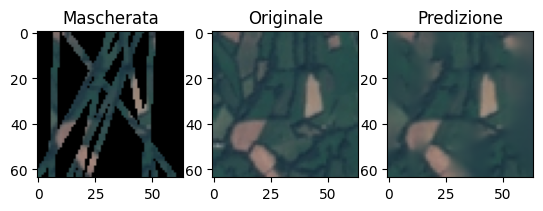

In [ ]:
# extract a single sample from test_generator
sample_batch = next(test_generator)
sample_image_masked, sample_image_original = sample_batch

# single image from the batch
input_image = sample_image_masked[0:1]  # we want only the first image

# make pred
prediction = model.predict(input_image)

# plot
plt.subplot(1, 3, 1)
plt.imshow(sample_image_masked[0])
plt.title('Mascherata')

plt.subplot(1, 3, 2)
plt.imshow(sample_image_original[0])
plt.title('Originale')

plt.subplot(1, 3, 3)
plt.imshow(prediction[0])
plt.title('Predizione')

plt.show()

## Prestazioni

Valutiamo il modello attraverso la metrica del Mean Square Error su 10000 immagini dal test set, per 10 volte. In linea di massima si é cercato di tenere un compromesso tra la dimensione della rete e la metrica proposta per la valutazione.

Output streaming troncato alle ultime 5000 righe.
1/1 [==============================] - 0s 31ms/step
Media MSE su 10 iterazioni (Keras): 0.002419587690383196
Deviazione standard MSE su 10 iterazioni (Keras): 0.0015384404687210917


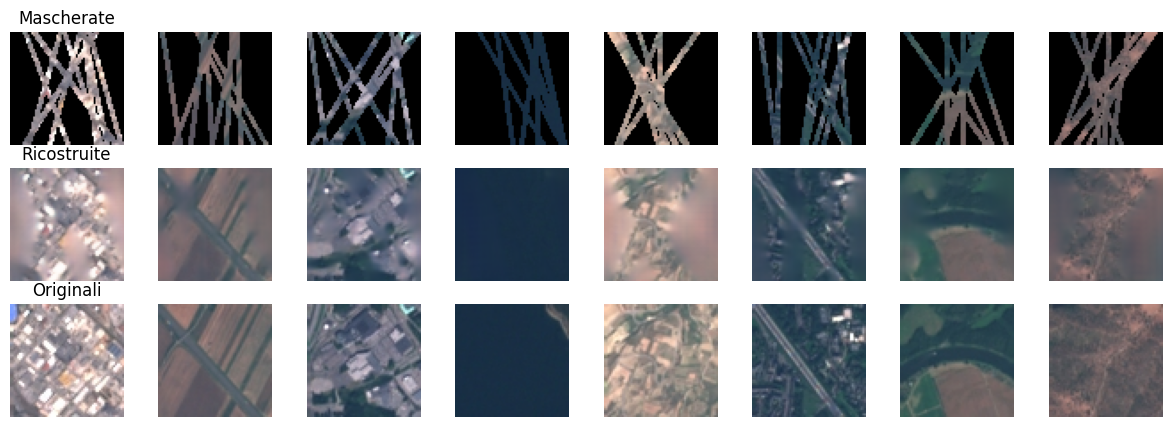

In [ ]:
mse_values_keras = []
for _ in range(10):
    mse_total_keras = 0.0
    mse_total_keras = 0.0
    num_images = 10000

    # Save for plots
    sample_images = {'input': [], 'reconstructed': [], 'original': []}

    for _ in range(num_images // batch_size):
        input_images, target_images = next(test_generator)
        reconstructed_images = model.predict(input_images)

        # uso keras, ma si poteva usare anche scikit-learn
        # non ci sono differenze particolari
        mse_batch_keras = keras_mse(target_images, reconstructed_images).numpy()
        mse_total_keras += mse_batch_keras

        # samples per il plotting
        sample_images['input'].extend(input_images)
        sample_images['reconstructed'].extend(reconstructed_images)
        sample_images['original'].extend(target_images)

    mse_values_keras.append(mse_total_keras / (num_images // batch_size))

# Media e deviazione standard sull'MSE utilizzando Keras
mean_mse_keras = np.mean(mse_values_keras)
std_dev_mse_keras = np.std(mse_values_keras)

print(f"Media MSE su 10 iterazioni (Keras): {mean_mse_keras}")
print(f"Deviazione standard MSE su 10 iterazioni (Keras): {std_dev_mse_keras}")

# 10 samples
fig, axes = plt.subplots(3, 8, figsize=(15, 5))
axes = axes.flatten()

for i in range(8):
    axes[i].imshow(sample_images['input'][i])
    axes[i + 8].imshow(sample_images['reconstructed'][i])
    axes[i + 16].imshow(sample_images['original'][i])

    axes[i].axis('off')
    axes[i + 8].axis('off')
    axes[i + 16].axis('off')

axes[0].set_title('Mascherate')
axes[8].set_title('Ricostruite')
axes[16].set_title('Originali')

plt.show()


# Salvataggio modello e pesi

In [ ]:
model.save('inceptunet.keras')
model.save_weights('inceptunet_weights')